**Importing the NHIS data into a pandas dataframe**

In [1]:
# The data was downloaded from IPUMS and then formatted into a STATA data file
# Importing necessary libraries for the entire project

import numpy as np
import pandas as pd
import sqlite3
from matplotlib import style
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf

style.use("seaborn-colorblind")

# The rdd library allows us to calculate the optimal bandwidth to select our sample
from rdd import rdd

# Defining the filepath that contains the NHIS data, reading it in, and putting into a pandas dataframe

dtafile = r'C:\Users\devin\Documents\School\ECON6060FinalProject\NHIS2000-2004.dta'
df = pd.read_stata(dtafile)

# Outputting a sample of the dataframe to make sure it loaded in correctly

print(df.tail())

# Putting the data into a SQLite database

con = sqlite3.connect(r'C:\Users\devin\Documents\School\ECON6060FinalProject\ProjectData.sqlite')
df.to_sql("initial_data", con, if_exists="replace")
con.close()

        year  serial  strata  psu         nhishid  hhweight     region  \
481367  2004   42087    5058    1  00002004071562      2491  Northeast   
481368  2004   42088    5058    2  00002004071567      2487  Northeast   
481369  2004   42088    5058    2  00002004071567      2487  Northeast   
481370  2004   42088    5058    2  00002004071567      2487  Northeast   
481371  2004   42088    5058    2  00002004071567      2487  Northeast   

        pernum           nhispid     hhx  ...  \
481367       2  0020040715620102  071562  ...   
481368       1  0020040715670101  071567  ...   
481369       2  0020040715670102  071567  ...   
481370       3  0020040715670103  071567  ...   
481371       4  0020040715670104  071567  ...   

                                            usborn racenew  height  \
481367  No, born outside U.S. and U.S. territories   White     NIU   
481368                           Yes, born in U.S.   White     NIU   
481369                           Yes, born in U.S.

**Cleaning the data and creating necessary variables**

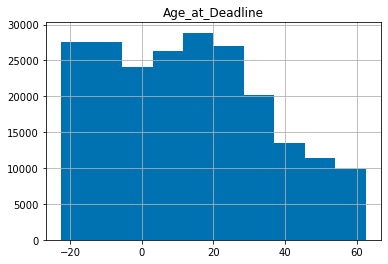

In [2]:
# Querying the database and limiting the sample to just women who have a birth
# year that isn't missing

con = sqlite3.connect(r'C:\Users\devin\Documents\School\ECON6060FinalProject\ProjectData.sqlite')
restricted = pd.read_sql_query("""SELECT * 
                               FROM initial_data 
                               WHERE sex = 'Female' AND birthyr < 2001""", con)
con.close()

# Creating dummy variables for region of residence at time of survey
restricted['Northeast'] = np.where(restricted['region'] == 'Northeast', 1, 0)

restricted['Midwest'] = np.where(restricted['region'] == 'North Central/Midwest', 1, 0)

restricted['South'] = np.where(restricted['region'] == 'South', 1, 0)

restricted['West'] = np.where(restricted['region'] == 'West', 1, 0)

# Checking if the dummies are mutually exclusive and exhaustive

assert (restricted['Northeast'] + restricted['Midwest'] + restricted['South'] + restricted['West']).eq(1).all() == 1

# Creating the age variable which will be used as the running variable for the regression discontinuity analysis
# It is calculated to be the age of the individual in July of 1978

restricted.loc[restricted['birthmo'] == 'January', 'birthmo_num'] = 1
restricted.loc[restricted['birthmo'] == 'February', 'birthmo_num'] = 2
restricted.loc[restricted['birthmo'] == 'March', 'birthmo_num'] = 3
restricted.loc[restricted['birthmo'] == 'April', 'birthmo_num'] = 4
restricted.loc[restricted['birthmo'] == 'May', 'birthmo_num'] = 5
restricted.loc[restricted['birthmo'] == 'June', 'birthmo_num'] = 6
restricted.loc[restricted['birthmo'] == 'July', 'birthmo_num'] = 7
restricted.loc[restricted['birthmo'] == 'August', 'birthmo_num'] = 8
restricted.loc[restricted['birthmo'] == 'September', 'birthmo_num'] = 9
restricted.loc[restricted['birthmo'] == 'October', 'birthmo_num'] = 10
restricted.loc[restricted['birthmo'] == 'November', 'birthmo_num'] = 11
restricted.loc[restricted['birthmo'] == 'December', 'birthmo_num'] = 12

restricted['Age_at_Deadline'] = (1978 + (7/12)) - (restricted['birthyr'] + (restricted['birthmo_num'] / 12))

# Restricting the sample to only those with a birth month
    
restricted = restricted[restricted.birthmo != 'Unknown-refused']
restricted = restricted[restricted.birthmo != 'Unknown-not ascertained']
restricted = restricted[restricted.birthmo != "Unknown-don't know"]

hist = restricted.hist('Age_at_Deadline')

# Creating dummy variables for race and ethnicity

restricted['Hispanic'] = np.where(restricted['hispyn'] == 'Yes, of Hispanic ethnicity', 1, 0)

restricted['White'] = np.where(((restricted['racenew'] == 'White') & (restricted['Hispanic'] == 0)), 1, 0)

restricted['Black'] = np.where(((restricted['racenew'] == 'Black/African American') & (restricted['Hispanic'] == 0)), 1, 0)

restricted['Other'] = np.where(((restricted['Hispanic'] == 0) & (restricted['White'] == 0) & (restricted['Black'] == 0)), 1, 0)

# Checking if the dummies are mutually exclusive and exhaustive

assert (restricted['Hispanic'] + restricted['White'] + restricted['Black'] + restricted['Other']).eq(1).all() == 1

# Creating a dummy variable for if they were born in the US or not

restricted['US_born_dummy'] = np.where(restricted['usborn'] == 'Yes, born in U.S.', 1 , 0)

# Creating a dummy variable and a continuous variable for height

restricted['Exceptional_Height'] = np.where(restricted['height'] == \
                                            'Exceptionally short or tall (2019-forward: or sex is unknown)', 1, 0)

# Creating the lifestyle variables
    
    # Drinking
    
restricted['Drinker'] = np.where(restricted['alcstat1'] == 'Current drinker (1+ drinks past year)', 1, 0)

    # Smoking
    
restricted['Smoker'] = np.where(((restricted['smokestatus2'] == 'Current every day smoker') | \
                                 (restricted['smokestatus2'] == 'Current some day smoker')), 1, 0)

    # Exercise
    
        # Values of 997, 998, and 999 indicated unknown values, so these observations are dropped
    
restricted = restricted[restricted.mod10dmin < 997]

restricted = restricted[restricted.vig10dmin < 997]
    
restricted['moderate_exercise'] = restricted['mod10dmin'] * restricted['mod10fwk']

restricted['vigorous_exercise'] = restricted['vig10dmin'] * restricted['vig10fwk']

        # Values of 94 (less than once per week), 95 (never), and 96 (unable to do this activity) are treated as zeroes
        # I'm creating both a dummy variable (which takes a value of 1 if the respondent does any strength-increasing
        # exercises, and 0 if not) and a variable which contains the number of times the respondent does
        # strength-increasing exercises per week

restricted['strong_dummy'] = np.where(((restricted['strongfwk'] < 94) & (restricted['strongfwk'] > 0)), 1, 0)

restricted['strong_freq'] = restricted['strongfwk']
restricted.loc[restricted['strong_freq'] > 93, 'strong_freq'] = 0

# Rescaling the weights due to pooling 5 years of data

restricted['perweight'] = restricted['perweight'] / 5

# Putting the dataframe into the SQLite database

con = sqlite3.connect(r'C:\Users\devin\Documents\School\ECON6060FinalProject\ProjectData.sqlite')
restricted.to_sql("restricted", con, if_exists="replace")
con.close()

**Calculating the difference in means for "baseline" characteristics and running the regression discontinuity**

Optimal bandwidth :  2.0677778526186157
   Hispanic     White     Black     Other   US_born  exc_height     N
0  0.107016  0.721840  0.121117  0.050027  0.849543    0.027917  7130
1  0.111123  0.710873  0.128596  0.049408  0.851575    0.028379  6999
                            WLS Regression Results                            
Dep. Variable:                Drinker   R-squared:                       0.147
Model:                            WLS   Adj. R-squared:                  0.090
Method:                 Least Squares   F-statistic:                     2.230
Date:                Wed, 28 Apr 2021   Prob (F-statistic):             0.0977
Time:                        20:51:43   Log-Likelihood:                 102.80
No. Observations:                  49   AIC:                            -197.6
Df Residuals:                      45   BIC:                            -190.0
Df Model:                           3                                         
Covariance Type:                  HC1  

                            WLS Regression Results                            
Dep. Variable:           strong_dummy   R-squared:                       0.006
Model:                            WLS   Adj. R-squared:                 -0.060
Method:                 Least Squares   F-statistic:                   0.09127
Date:                Wed, 28 Apr 2021   Prob (F-statistic):              0.964
Time:                        20:51:44   Log-Likelihood:                 116.49
No. Observations:                  49   AIC:                            -225.0
Df Residuals:                      45   BIC:                            -217.4
Df Model:                           3                                         
Covariance Type:                  HC1                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

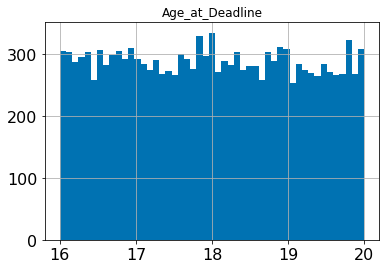

In [20]:
# Now that the variables are ready, it's time to run the regression discontinuity analysis and calculate sample means

# Creating the function which will do the regression discontinuity analysis

def regression_discontinuity(variable):

    model = smf.wls(f"{variable}~Age_at_Deadline * treated", final_rdd).fit(cov_type = "HC1")

    print(model.summary())

    final_rdd['predictions'] = model.fittedvalues

    final_rdd_treat = final_rdd[final_rdd['Age_at_Deadline'] < 0]
    final_rdd_untreat = final_rdd[final_rdd['Age_at_Deadline'] >= 0]

    graph = final_rdd.plot.scatter(x="Age_at_Deadline", y=f"{variable}")
    plt.plot(final_rdd_treat['Age_at_Deadline'], final_rdd_treat['predictions'], color = "C2", label = "Linear Fit")
    plt.plot(final_rdd_untreat['Age_at_Deadline'], final_rdd_untreat['predictions'], color = "C2")
    plt.xlabel("Centralized Age at Deadline", fontsize = "xx-large")
    plt.rc('xtick', labelsize = 16)
    plt.rc('ytick', labelsize = 16)
    plt.rc('legend', fontsize = 18)
    plt.legend()
    plt.axvline(x = 0, ymin = 0, color = "C1")
    plt.gcf().set_size_inches(16, 12)

# Creating weighted averages of the necessary variables by Age_at_Deadline

con = sqlite3.connect(r'C:\Users\devin\Documents\School\ECON6060FinalProject\ProjectData.sqlite')
final_rdd = pd.read_sql_query("""SELECT SUM(perweight*Hispanic) / SUM(perweight) AS Hispanic, 
                              SUM(perweight*White) / SUM(perweight) as White, SUM(perweight*Black) / SUM(perweight) as Black, 
                              SUM(perweight*Other) / SUM(perweight) AS Other, 
                              SUM(perweight*US_born_dummy) / SUM(perweight) AS US_born, 
                              SUM(perweight*Exceptional_Height) / SUM(perweight) AS exc_height, 
                              SUM(perweight*Drinker) / SUM(perweight) AS Drinker, 
                              SUM(perweight*Smoker) / SUM(perweight) AS Smoker,
                              SUM(perweight*moderate_exercise) / SUM(perweight) AS moderate_exercise,
                              SUM(perweight*vigorous_exercise) / SUM(perweight) AS vigorous_exercise,
                              SUM(perweight*strong_dummy) / SUM(perweight) AS strong_dummy,
                              SUM(perweight*strong_freq) / SUM(perweight) AS strong_freq, COUNT(*) AS N, Age_at_Deadline
                              FROM restricted
                              GROUP BY Age_at_Deadline""", con)
con.close()

# Calculating the optimal bandwidth

optimal_bandwidth = rdd.optimal_bandwidth(final_rdd['strong_freq'], final_rdd['Age_at_Deadline'], 18)
print('Optimal bandwidth : ', optimal_bandwidth)

# Restricting the sample to those in the optimal bandwidth

final_rdd = final_rdd[final_rdd['Age_at_Deadline'] < (18 + optimal_bandwidth)]
final_rdd = final_rdd[final_rdd['Age_at_Deadline'] > (18 - optimal_bandwidth)]

final_means = restricted[restricted['Age_at_Deadline'] < (18 + optimal_bandwidth)]
final_means = final_means[final_means['Age_at_Deadline'] > (18 - optimal_bandwidth)]

hist2 = final_means.hist('Age_at_Deadline', bins = 49)

# Calculating means for "baseline" attributes and outcomes for the treated and untreated groups, 
# as well as the difference in means

    # Creating a couple dummy variables for treatment/non-treatment status
    
final_rdd['treated'] = np.where(final_rdd['Age_at_Deadline'] < 18, 1, 0)
final_rdd['untreated'] = np.where(final_rdd['Age_at_Deadline'] >= 18, 1 , 0)

assert (final_rdd['treated'] + final_rdd['untreated']).eq(1).all() == 1

final_means['treated'] = np.where(final_means['Age_at_Deadline'] < 18, 1, 0)
final_means['untreated'] = np.where(final_means['Age_at_Deadline'] >= 18, 1 , 0)

assert (final_means['treated'] + final_means['untreated']).eq(1).all() == 1

    # Putting the 'final_means' dataframe into the SQL database so I can query it
    
con = sqlite3.connect(r'C:\Users\devin\Documents\School\ECON6060FinalProject\ProjectData.sqlite')
final_means.to_sql("final_means", con, if_exists="replace")
con.close()

    # Calculating the weighted sum of the "baseline" attributes
    
con = sqlite3.connect(r'C:\Users\devin\Documents\School\ECON6060FinalProject\ProjectData.sqlite')
sums_df = pd.read_sql_query("""SELECT SUM(perweight*Hispanic) / SUM(perweight) AS Hispanic, 
                              SUM(perweight*White) / SUM(perweight) as White, SUM(perweight*Black) / SUM(perweight) as Black, 
                              SUM(perweight*Other) / SUM(perweight) AS Other, 
                              SUM(perweight*US_born_dummy) / SUM(perweight) AS US_born, 
                              SUM(perweight*Exceptional_Height) / SUM(perweight) AS exc_height, COUNT(*) AS N
                              FROM final_means
                              GROUP BY treated""", con)
con.close()

print(sums_df)

# Normalizing the Age_at_Deadline variable

final_rdd['Age_at_Deadline'] = final_rdd['Age_at_Deadline'] - 18

# Running the regression discontinuity analysis using the function defined previously, calling it for each variable of interest

regression_discontinuity("Drinker")
plt.title("Prevalence of Women who Currently Drink", fontsize = "xx-large")
plt.ylabel("Percentage who are Current Drinkers", fontsize = "xx-large")
plt.savefig("Drinker_rdd.png")
plt.close()

regression_discontinuity("Smoker")
plt.title("Prevalence of Women who Currently Smoke", fontsize = "xx-large")
plt.ylabel("Percentage who are Current Smokers", fontsize = "xx-large")
plt.savefig("Smoker_rdd.png")
plt.close()

regression_discontinuity("moderate_exercise")
plt.title("Amount of Moderate Exercise by Women", fontsize = "xx-large")
plt.ylabel("Minutes of Moderate Exercise per Week", fontsize = "xx-large")
plt.savefig("moderate_exercise_rdd.png")
plt.close()

regression_discontinuity("vigorous_exercise")
plt.title("Amount of Vigorous Exercise by Women", fontsize = "xx-large")
plt.ylabel("Minutes of Vigorous Exercise per Week", fontsize = "xx-large")
plt.savefig("vigorous_exercise_rdd.png")
plt.close()

regression_discontinuity("strong_dummy")
plt.title("Prevalence of Women Who do Strength Improving Activities", fontsize = "xx-large")
plt.ylabel("Percentage who do Strength Improving Activities at Least Once a Week", fontsize = "xx-large")
plt.savefig("strong_dummy_rdd.png")
plt.close()

regression_discontinuity("strong_freq")
plt.title("Frequency of Strength Improving Activities by Women", fontsize = "xx-large")
plt.ylabel("Number of Times per Week", fontsize = "xx-large")
plt.savefig("strong_freq_rdd.png")
plt.close()